# CSE 627 Project 1- [House Price: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### *By Sooyeong Lim & Jason Zhao*




# Introduction

* **Why this competition?**

 The Kaggle competition we chose is *"House Price: Advanced Regression Techniques".* We selected this competition because of the following reasons:
 
 First, we can have a hands-on experience of high dimensional dataset. This dataset contains many features (# 79) with both quantitative variables and categorical variables and this data requires a lot of effort in feature engineering. This kind of high dimensional data is common in data science and having proper feature engineering skills is becomming an important skill. 
 
 Second, this project allows us to use various models we learned from CSE 627 class. Starts from Regularized model to Neural Network based model, we can try to implement and compare the performances of those algorithms. 
 
 Lastly, we can also learn how to handle missing variables. There are many missing variables in the dataset. By not just deleting the missing varaibles, we are going to *impute* the missing variables to utilize all the information we have as much as possible. 


* **Executive Conclusion**

 Among the fittied models, lasso regression showed the best performance and we ended on.

### Index 


* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#fe)
* [Modeling](#modeling) 
    * [Regularized model](#r)
    * [XGBoost](xgboost)
    * [Neural Network Based Model](#nn)
* [Results](#results) 
* [Limitations/Recommendations](#limitation)
* [Conclusion](#conclusion)
* [Reference/Resource](#reference)

<a id='eda'></a>
### Exploratory Data Analysis

 We checked that the overall trend of data distribution and relationship between predictors and the response variable. By doing EDA, we roughly got a direction of analysis and this provided an insight for the feature engineerning and modeling in the next chapter.

* **Import packages and train & test data**

In [235]:
# Import packages for EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [236]:
# Import train & test dataset
train=pd.read_csv('all/train.csv')
test=pd.read_csv('all/test.csv')

* **We are going to answer the following questions in EDA so that we can have a understanding of the problem:**


1. How many observations do we have? What is our concern? 
2. How many features are in the datset and how many categorical & quantitative features are in the dataset?
3. What does the response varialbe looks like?


In [237]:
print(len(train.index))
print(len(test.index))

1460
1459


1. A) The number of training and test observations is almost equal (1460 and 1459 for each cases). Our concern is the number of training data is relaitively small if we consdier the number of test data. We afraid that our model is overfitted to the training dataset. 

* **Predictor variables**

In [238]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [239]:
# List of Columns and except SalePrice this train.columns

2. A)As we can see from above, the features are a mixture categorical and quantitivative variables. After we looked into the data description in detail, we noticed that not all numerical values are quantitative variaibles. Maybe it can be ordinal dataset, however, some values are not quantitative variables. If the features have some semantic characteristics, we changed it in the feature engineering part.

* Response variable

In [240]:
train['SalePrice'].describe()
#Rough information of Response variable.. there is no 0's median, mean.. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x11656fc50>,
 'caps': [<matplotlib.lines.Line2D at 0x1165725c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11656fac8>],
 'medians': [<matplotlib.lines.Line2D at 0x116572e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x116571320>],
 'means': []}

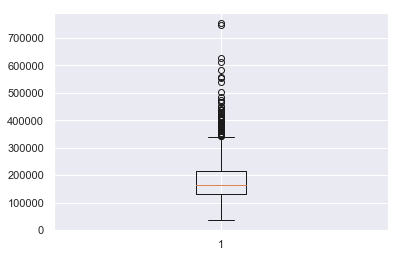

In [241]:
plt.boxplot(train['SalePrice'])

3. A)From the boxplot, it seems like the distribution of response variable is right skwed. It means that most of observations are gathered around Q1 and Q3. The histogram below also support this finding.

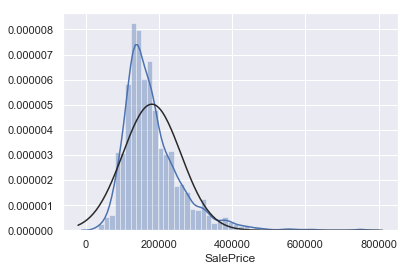

In [242]:
sns.distplot(train['SalePrice'],fit=norm)

This skewedness of SalePrice can be problametic because our regression-based model assumes that Y follows a normal distribution. 
One technique we can use is log-transformation to make it normal distribution. By the super-imposed pdf line, we verified that this skewed dataset is not fitting to the normality assumption.

#Distribution of Y variable --> Take a log 
*Assumption biolation

Y~ N(XB,$\sigma^{2}$)

Normality assumption check


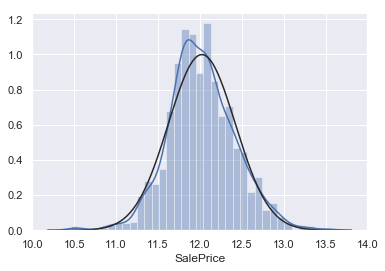

In [243]:
sns.distplot(np.log(train['SalePrice']), fit=norm)

In [244]:
##QQ plot assumption checking should be included

After we checked this skewedness, we log-transformed the response variable. The new distribution plot shows that the data matches the normal distribution.

* Correlation and Relationship between response and predictor variables

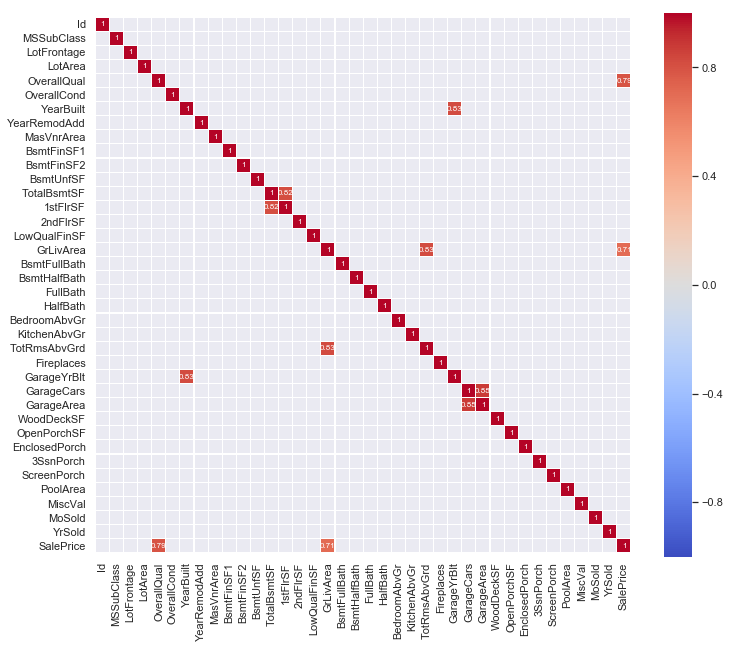

In [245]:
cor_mat=train.corr()
best_feat = train
corr =best_feat.corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

The heatmap plot provides us which variables are correlated with. High correlationship suggest that the amount of information is similar. In this case, we don't have to contain both of variables in the model. It seems like GarageCars and GrageArea provides almost equal information and it make sense that if the garage can contain more cars then the size of area of garage naturally increases as well.

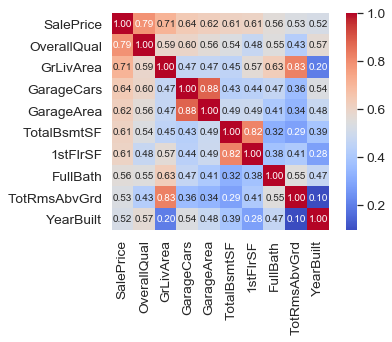

In [246]:
#Select top 10 for making prediction
k=10
cols=cor_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm=np.corrcoef(train[cols].values.T)

sns.set(font_scale=1.25)
hm=sns.heatmap(cm,cmap='coolwarm', cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

This is the top 10 predictors in terms of correlation with SalePrice. For next step, we are going to provide pairplot between those variables and predictors.

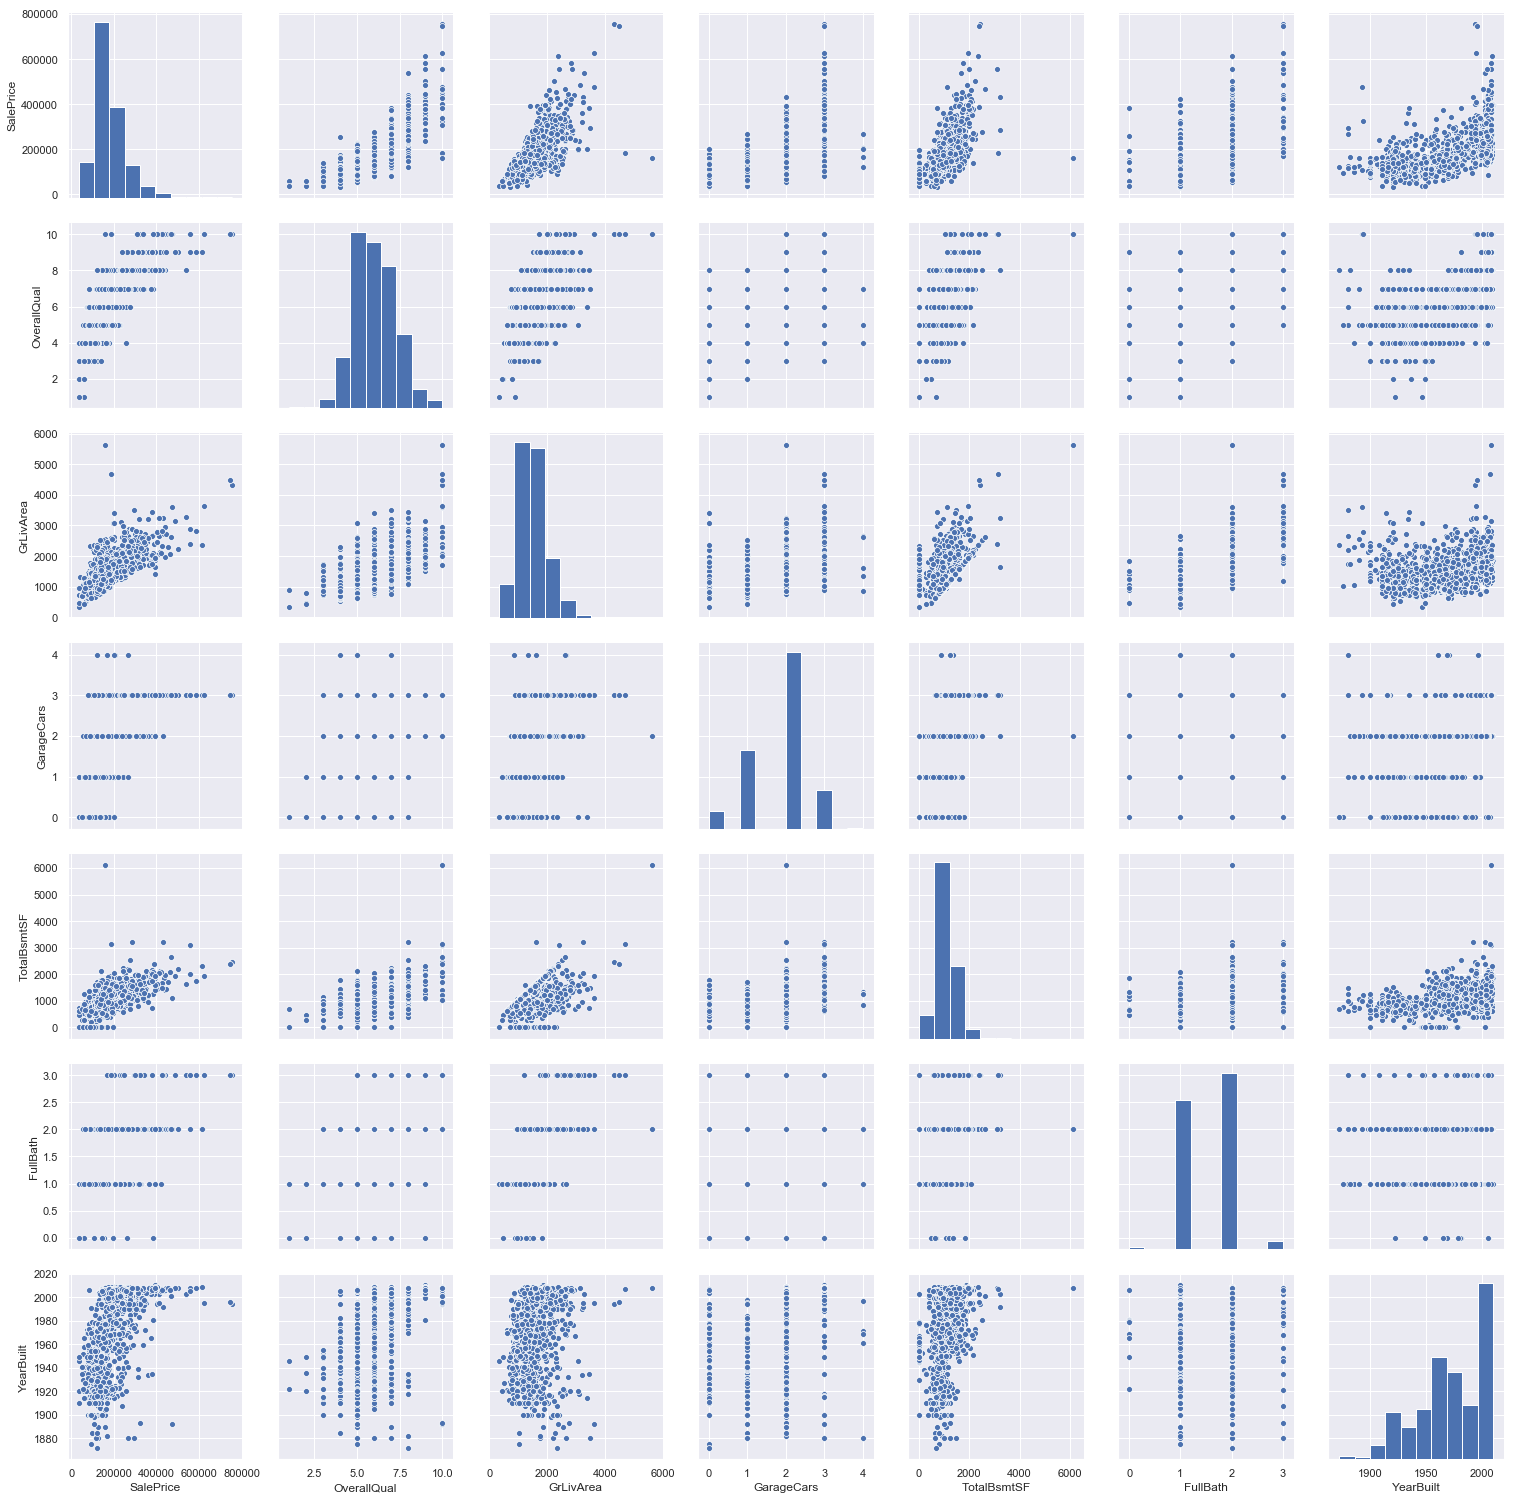

In [247]:
sns.set()
cols=['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols],size=3)
plt.show()

We can see a linear relationship or quadratic relationship between OverallQual and SalePrice. We detect that there are two outliers in GRLivArea and one outlier in inTotalBmtSF. In feature engieering section, we are going to delete those observations from the training dataset.



* Explain why noramlity assumtpion is requried, show proper label

<a id='fe'></a>
### Feature Engineering

 A lot of effort in Feature Engineering is involved for this problem. There are many missing observations for the train and test dataset so we imputed by using some tricks. We combined the train and test datasets all together and impute them to harness all the information we can have without violating any Kaggle competition's rule.
 
For categorical data, there are some semantic characteristics. After plotting the dataset we realized that the relationship between X and Y is not just a linear relationship. 


Drop Id, since it is not relevant to the selling price.

In [248]:
# Import train & test dataset
train_data=pd.read_csv('all/train.csv')
test_data=pd.read_csv('all/test.csv')

In [249]:
train_data.drop('Id',axis=1,inplace=True)

Take log of the sales price

Check missing values.

In [250]:
# check the missing data rate
train_data_na = (train_data.isnull().sum() / len(train_data)) * 100
train_data_na = train_data_na.drop(train_data_na[train_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_data_na})
missing_data

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Based on data description file, we find out most of them are missing is because that house does not have that. Therefore, we will replace those by None. In this case missing value is not actually meaning we convert it

In [251]:
# PoolQC with NaN means no pool, so we put None instead
train_data.PoolQC = train_data.PoolQC.fillna("None")
test_data.PoolQC = test_data.PoolQC.fillna("None")

In [252]:
# MiscFeature: Miscellaneous feature not covered in other categories
# NA means None, so we repaced with None
train_data.MiscFeature = train_data.MiscFeature.fillna("None")
test_data.MiscFeature = test_data.MiscFeature.fillna("None")

In [253]:
# If Alley is NA means there is no Alley access, so we change it to None
train_data.Alley = train_data.Alley.fillna("None")
test_data.Alley = test_data.Alley.fillna("None")

In [254]:
# If Fence is NA means there is no Fence
train_data.Fence = train_data.Fence.fillna("None")
test_data.Fence = test_data.Fence.fillna("None")

In [255]:
# If FireplaceQu is NA means there is no Fireplace
train_data.FireplaceQu = train_data.FireplaceQu.fillna("None")
test_data.FireplaceQu = test_data.FireplaceQu.fillna("None")

In [256]:
# If the house does not have a garage, GarageType GarageFinish GarageQual and GarageCond will be Na
for column in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    train_data[column] = train_data[column].fillna("None")
    test_data[column] = test_data[column] .fillna("None")

In [257]:
# If there is no basement, BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual will be Na,
for column in ("BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual"):
    train_data[column] = train_data[column].fillna("None")
    test_data[column] = test_data[column] .fillna("None")

In [258]:
# Masonry veneer type
train_data.MasVnrType = train_data.MasVnrType.fillna("None")
test_data.MasVnrType = test_data.MasVnrType.fillna("None")

In [259]:
# since there is no garage, so we will set the year build at 0
train_data.GarageYrBlt = train_data.GarageYrBlt.fillna(0)
test_data.GarageYrBlt = test_data.GarageYrBlt.fillna(0)

# for testing data, GarageArea and GarageCars also has missing vlaue, we set them to 0 because they does not have garage
test_data.GarageArea = test_data.GarageArea.fillna(0)
test_data.GarageCars = test_data.GarageCars.fillna(0)

In [260]:
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(0)
test_data["MasVnrArea"] = test_data['MasVnrArea'].fillna(0)

In [261]:
test_data["TotalBsmtSF"] = test_data['TotalBsmtSF'].fillna(0)
test_data["BsmtFinSF1"] = test_data['BsmtFinSF1'].fillna(0)
test_data["BsmtFinSF2"] = test_data['BsmtFinSF2'].fillna(0)
test_data["BsmtUnfSF"] = test_data['BsmtUnfSF'].fillna(0)

In [262]:
test_data.MSZoning = test_data.MSZoning.fillna('RL')
test_data.Utilities = test_data.Utilities.fillna('AllPub')
test_data.Exterior1st = test_data.Exterior1st.fillna('VinylSd')
test_data.Exterior2nd = test_data.Exterior2nd.fillna('VinylSd')
test_data.BsmtFullBath = test_data.BsmtFullBath.fillna(0)
test_data.BsmtHalfBath = test_data.BsmtHalfBath.fillna(0)
test_data.KitchenQual = test_data.KitchenQual.fillna('TA')
test_data.Functional = test_data.Functional.fillna('Typ')
test_data.SaleType = test_data.SaleType.fillna('WD')

After replacing, we check which data are still missing.

In [263]:
# check the missing data rate
train_data_na = (train_data.isnull().sum() / len(train_data)) * 100
train_data_na = train_data_na.drop(train_data_na[train_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_data_na})
missing_data

,Missing Ratio
LotFrontage,17.739726
Electrical,0.068493


We want to encode every string data to check correlations.

In [264]:
list(train_data.select_dtypes(exclude=['int', 'float']).columns.values)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [265]:
train_data.MSZoning = train_data.MSZoning.map({'RL':0, 'RM':1, 'FV':2, 'RH':3, 'C (all)':4})
test_data.MSZoning = test_data.MSZoning.map({'RL':0, 'RM':1, 'FV':2, 'RH':3, 'C (all)':4})

In [266]:
train_data.Street = train_data.Street.map({'Grvl' : 1, 'Pave' : 2})
test_data.Street = test_data.Street.map({'Grvl' : 1, 'Pave' : 2})

In [267]:
train_data.Alley = train_data.Alley.map({'None':0, 'Grvl' : 1, 'Pave' : 2})
test_data.Alley = test_data.Alley.map({'None':0, 'Grvl' : 1, 'Pave' : 2})

In [268]:
train_data.LotShape = train_data.LotShape.map({"Reg" : 1, "IR1" : 2, "IR2" : 3, "IR3" : 4})
test_data.LotShape = test_data.LotShape.map({"Reg" : 1, "IR1" : 2, "IR2" : 3, "IR3" : 4})

In [269]:
train_data.LandContour = train_data.LandContour.map({
    'Lvl' : 1,
    'Bnk' : 2,
    'HLS' : 3,
    'Low' : 4
})
test_data.LandContour = test_data.LandContour.map({
    'Lvl' : 1,
    'Bnk' : 2,
    'HLS' : 3,
    'Low' : 4
})

In [270]:
train_data.Utilities = train_data.Utilities.map({
    'AllPub' : 1,
    'NoSewr' : 2,
    'NoSeWa' : 3,
    'ELO' :4
})
test_data.Utilities = test_data.Utilities.map({
    'AllPub' : 1,
    'NoSewr' : 2,
    'NoSeWa' : 3,
    'ELO' :4
})

In [271]:
train_data.LotConfig = train_data.LotConfig.map({
    'Inside' : 1,
    'Corner' : 2,
    'CulDSac' : 3,
    'FR2' : 4,
    'FR3' : 5
})
test_data.LotConfig = test_data.LotConfig.map({
    'Inside' : 1,
    'Corner' : 2,
    'CulDSac' : 3,
    'FR2' : 4,
    'FR3' : 5
})

In [272]:
train_data.LandSlope = train_data.LandSlope.map({
    'Gtl' : 3,
    'Mod' : 2,
    'Sev' : 1
})
test_data.LandSlope = test_data.LandSlope.map({
    'Gtl' : 3,
    'Mod' : 2,
    'Sev' : 1
})

In [273]:
Neighborhoodkeys =  train_data.Neighborhood.unique()
NeighborhoodMap = {}
i = 1
for key in Neighborhoodkeys:
    NeighborhoodMap[key] = i
    i += 1

In [274]:
train_data.Neighborhood = train_data.Neighborhood.map(NeighborhoodMap)
test_data.Neighborhood = test_data.Neighborhood.map(NeighborhoodMap)

In [275]:
ConditionMap = {'Norm': 3, 'Feedr': 4, 'PosN': 2, 'Artery': 4, 'RRAe': 1, 'RRNn': 1, 'RRAn': 1, 'PosA': 2, 'RRNe': 1}

train_data.Condition1 = train_data.Condition1.map(ConditionMap)
train_data.Condition2 = train_data.Condition2.map(ConditionMap)
test_data.Condition1 = test_data.Condition1.map(ConditionMap)
test_data.Condition2 = test_data.Condition2.map(ConditionMap)

In [276]:
train_data.BldgType = train_data.BldgType.map({'1Fam': 5, '2fmCon' :4, 'Duplex' :3, 'TwnhsE': 2, 'Twnhs':1})
test_data.BldgType = test_data.BldgType.map({'1Fam': 5, '2fmCon' :4, 'Duplex' :3, 'TwnhsE': 2, 'Twnhs':1})

In [277]:
train_data.HouseStyle = train_data.HouseStyle.map({'2Story': 1, '1Story': 2, '1.5Fin': 3, '1.5Unf': 4, 'SFoyer': 5, 'SLvl': 6, '2.5Unf': 7, '2.5Fin': 8})
test_data.HouseStyle = test_data.HouseStyle.map({'2Story': 1, '1Story': 2, '1.5Fin': 3, '1.5Unf': 4, 'SFoyer': 5, 'SLvl': 6, '2.5Unf': 7, '2.5Fin': 8})

In [278]:
train_data.RoofStyle = train_data.RoofStyle.map({'Gable': 1, 'Hip': 2, 'Gambrel': 3, 'Mansard': 4, 'Flat': 5, 'Shed': 6})
test_data.RoofStyle = test_data.RoofStyle.map({'Gable': 1, 'Hip': 2, 'Gambrel': 3, 'Mansard': 4, 'Flat': 5, 'Shed': 6})

In [279]:
train_data.RoofMatl = train_data.RoofMatl.map({'CompShg': 1, 'WdShngl': 2, 'Metal': 3, 'WdShake': 4, 'Membran': 5, 'Tar&Grv': 6, 'Roll': 7, 'ClyTile': 8})
test_data.RoofMatl = test_data.RoofMatl.map({'CompShg': 1, 'WdShngl': 2, 'Metal': 3, 'WdShake': 4, 'Membran': 5, 'Tar&Grv': 6, 'Roll': 7, 'ClyTile': 8})

In [280]:
e2K =  train_data.Exterior2nd.unique()
e2M = {}
i = 1
for key in e2K:
    e2M[key] = i
    i += 1

In [281]:
ExteriorMap = {'VinylSd': 1, 'MetalSd': 2, 'Wd Sdng': 3, 'HdBoard': 4, 'BrkFace': 5, 'WdShing': 6, 'CemntBd': 7, 'Plywood': 8, 'AsbShng': 9, 'Stucco': 10, 'BrkComm': 11, 'AsphShn': 12, 'Stone': 13, 'ImStucc': 14, 'CBlock': 15, 'Other':0}
train_data.Exterior1st = train_data.Exterior1st.map(ExteriorMap)
train_data.Exterior2nd = train_data.Exterior2nd.map(e2M)
test_data.Exterior1st = test_data.Exterior1st.map(ExteriorMap)
test_data.Exterior2nd = test_data.Exterior2nd.map(e2M)

In [282]:
# since has none, so we just samplify this featrue
train_data.MasVnrType = train_data.MasVnrType.map({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})
test_data.MasVnrType = test_data.MasVnrType.map({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})

In [283]:
conditionMap = {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}

In [284]:
train_data.ExterCond = train_data.ExterCond.map(conditionMap)
test_data.ExterCond = test_data.ExterCond.map(conditionMap)
train_data.ExterQual = train_data.ExterQual.map(conditionMap)
test_data.ExterQual = test_data.ExterQual.map(conditionMap)
train_data.BsmtQual = train_data.BsmtQual.map(conditionMap)
test_data.BsmtQual = test_data.BsmtQual.map(conditionMap)
train_data.BsmtCond = train_data.BsmtCond.map(conditionMap)
test_data.BsmtCond = test_data.BsmtCond.map(conditionMap)
train_data.HeatingQC = train_data.HeatingQC.map(conditionMap)
test_data.HeatingQC = test_data.HeatingQC.map(conditionMap)
train_data.KitchenQual = train_data.KitchenQual.map(conditionMap)
test_data.KitchenQual = test_data.KitchenQual.map(conditionMap)
train_data.FireplaceQu = train_data.FireplaceQu.map(conditionMap)
test_data.FireplaceQu = test_data.FireplaceQu.map(conditionMap)
train_data.GarageQual = train_data.GarageQual.map(conditionMap)
test_data.GarageQual = test_data.GarageQual.map(conditionMap)
train_data.GarageCond = train_data.GarageCond.map(conditionMap)
test_data.GarageCond = test_data.GarageCond.map(conditionMap)
train_data.PoolQC = train_data.PoolQC.map(conditionMap)
test_data.PoolQC = test_data.PoolQC.map(conditionMap)

In [285]:
train_data.Foundation = train_data.Foundation.map({'PConc': 1, 'CBlock': 2, 'BrkTil': 3, 'Wood': 4, 'Slab': 5, 'Stone': 6})
test_data.Foundation = test_data.Foundation.map({'PConc': 1, 'CBlock': 2, 'BrkTil': 3, 'Wood': 4, 'Slab': 5, 'Stone': 6})

In [286]:
train_data.BsmtExposure = train_data.BsmtExposure.map({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3, "None" : 0})
test_data.BsmtExposure = test_data.BsmtExposure.map({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3, "None" : 0})

In [287]:
BsmtFinTypeMap = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}

In [288]:
train_data.BsmtFinType1 = train_data.BsmtFinType1.map(BsmtFinTypeMap)
train_data.BsmtFinType2 = train_data.BsmtFinType2.map(BsmtFinTypeMap)
test_data.BsmtFinType1 = test_data.BsmtFinType1.map(BsmtFinTypeMap)
test_data.BsmtFinType2 = test_data.BsmtFinType2.map(BsmtFinTypeMap)

In [289]:
train_data.Heating = train_data.Heating.map({'GasA': 1, 'GasW': 2, 'Grav': 3, 'Wall': 4, 'OthW': 5, 'Floor': 6})
test_data.Heating = test_data.Heating.map({'GasA': 1, 'GasW': 2, 'Grav': 3, 'Wall': 4, 'OthW': 5, 'Floor': 6})

In [290]:
train_data.CentralAir = train_data.CentralAir.map({'Y': 1, 'N': 0})
test_data.CentralAir = test_data.CentralAir.map({'Y': 1, 'N': 0})

In [291]:
train_data.Electrical = train_data.Electrical.map({'SBrkr': 1, 'FuseF': 2, 'FuseA': 3, 'FuseP': 4, 'Mix': 5})
test_data.Electrical = test_data.Electrical.map({'SBrkr': 1, 'FuseF': 2, 'FuseA': 3, 'FuseP': 4, 'Mix': 5})

In [292]:
train_data.Functional = train_data.Functional.map({'Typ':0, 'Min2':1, 'Min1':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6})
test_data.Functional = test_data.Functional.map({'Typ':0, 'Min2':1, 'Min1':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6})

In [293]:
train_data.GarageType = train_data.GarageType.map({'Attchd':1, 'Detchd':2, 'BuiltIn':3, 'None':0, 'Basment':4, 'CarPort':5, '2Types':6})
test_data.GarageType = test_data.GarageType.map({'Attchd':1, 'Detchd':2, 'BuiltIn':3, 'None':0, 'Basment':4, 'CarPort':5, '2Types':6})

In [294]:
train_data.GarageFinish = train_data.GarageFinish.map({'RFn': 1, 'Unf': 2, 'Fin': 3, 'None': 0})
test_data.GarageFinish = test_data.GarageFinish.map({'RFn': 1, 'Unf': 2, 'Fin': 3, 'None': 0})

In [295]:
train_data.PavedDrive = train_data.PavedDrive.map({'Y':3, 'N':1, 'P':2})
test_data.PavedDrive = test_data.PavedDrive.map({'Y':3, 'N':1, 'P':2})

In [296]:
train_data.Fence = train_data.Fence.map({'None':0, 'MnPrv':1, 'GdPrv':2, 'GdWo':3, 'MnWw':4})
test_data.Fence = test_data.Fence.map({'None':0, 'MnPrv':1, 'GdPrv':2, 'GdWo':3, 'MnWw':4})

In [297]:
train_data.MiscFeature = train_data.MiscFeature.map({'None':0, 'Shed':1, 'Othr':2, 'Gar2':3, 'TenC':4})
test_data.MiscFeature = test_data.MiscFeature.map({'None':0, 'Shed':1, 'Othr':2, 'Gar2':3, 'TenC':4})

In [298]:
train_data.SaleType = train_data.SaleType.map({'WD': 1, 'New': 2, 'COD': 3, 'ConLD': 4, 'ConLI': 5, 'CWD': 6, 'ConLw': 7, 'Con': 8, 'Oth': 9})
test_data.SaleType = test_data.SaleType.map({'WD': 1, 'New': 2, 'COD': 3, 'ConLD': 4, 'ConLI': 5, 'CWD': 6, 'ConLw': 7, 'Con': 8, 'Oth': 9})

In [299]:
train_data.SaleCondition = train_data.SaleCondition.map({'Normal': 1, 'Abnorml': 2, 'Partial': 3, 'AdjLand': 4, 'Alloca': 5, 'Family': 6})
test_data.SaleCondition = test_data.SaleCondition.map({'Normal': 1, 'Abnorml': 2, 'Partial': 3, 'AdjLand': 4, 'Alloca': 5, 'Family': 6})


In [300]:
train_data["LotFrontage"] = train_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])
test_data["LotFrontage"] = test_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_data['Electrical'] = test_data['Electrical'].fillna(test_data['Electrical'].mode()[0])

In [301]:
# check the missing data rate
train_data_na = (train_data.isnull().sum() / len(train_data)) * 100
train_data_na = train_data_na.drop(train_data_na[train_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_data_na})
missing_data

,Missing Ratio


In [302]:
# check the missing data rate
test_data_na = (test_data.isnull().sum() / len(test_data)) * 100
test_data_na = test_data_na.drop(test_data_na[test_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_data_na})
missing_data

,Missing Ratio


After enconding, all of features' datatype has became int or float.

We tried to inpute those missing value, but after inpute, all datatype has bcame float which cause more problem, so we just chose to fill those data by mean value.

In [303]:
correlated = train_data.corr()
correlated = correlated.loc['SalePrice']
correlated = correlated.sort_values(ascending=False)

print(correlated.head(15))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [325]:
# drop outliers
train_data = train_data.drop([523,1298])

We also tried different featur enginering

In [84]:
# ## Try different feature engineering with our model

# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

# warnings.simplefilter('ignore', np.RankWarning)

# x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
# y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]

# t = (x <= 25000) & (y <= 150)

# p = np.polyfit(x[t], y[t], 1)

# all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

# all_data = all_data.fillna({
#     'Alley' : 'NoAlley',
#     'MasVnrType': 'None',
#     'FireplaceQu': 'NoFireplace',
#     'GarageType': 'NoGarage',
#     'GarageFinish': 'NoGarage',
#     'GarageQual': 'NoGarage',
#     'GarageCond': 'NoGarage',
#     'BsmtFullBath': 0,
#     'BsmtHalfBath': 0,
#     'BsmtQual' : 'NoBsmt',
#     'BsmtCond' : 'NoBsmt',
#     'BsmtExposure' : 'NoBsmt',
#     'BsmtFinType1' : 'NoBsmt',
#     'BsmtFinType2' : 'NoBsmt',
#     'KitchenQual' : 'TA',
#     'MSZoning' : 'RL',
#     'Utilities' : 'AllPub',
#     'Exterior1st' : 'VinylSd',
#     'Exterior2nd'   : 'VinylSd',
#     'Functional' : 'Typ',
#     'PoolQC' : 'NoPool',
#     'Fence' : 'NoFence',
#     'MiscFeature' : 'None',
#     'Electrical' : 'SBrkr'

# })

# #all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'

# #all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'

# all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0

# all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0

# all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0

# #all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()

# all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0

# #all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()

# all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0

# #all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()

# #all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

# all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},

#                              'Street': {'Pave': 1, 'Grvl': 0 },

#                              'FireplaceQu': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1,

#                                             'NoFireplace': 0

#                                             },

#                              'Fence': {'GdPrv': 2,

#                                        'GdWo': 2,

#                                        'MnPrv': 1,

#                                        'MnWw': 1,

#                                        'NoFence': 0},

#                              'ExterQual': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1

#                                             },

#                              'ExterCond': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1

#                                             },

#                              'BsmtQual': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1,

#                                             'NoBsmt': 0},

#                              'BsmtExposure': {'Gd': 3,

#                                             'Av': 2,

#                                             'Mn': 1,

#                                             'No': 0,

#                                             'NoBsmt': 0},

#                              'BsmtCond': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1,

#                                             'NoBsmt': 0},

#                              'GarageQual': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1,

#                                             'NoGarage': 0},

#                              'GarageCond': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1,

#                                             'NoGarage': 0},

#                              'KitchenQual': {'Ex': 5,

#                                             'Gd': 4,

#                                             'TA': 3,

#                                             'Fa': 2,

#                                             'Po': 1},

#                              'Functional': {'Typ': 0,

#                                             'Min1': 1,

#                                             'Min2': 1,

#                                             'Mod': 2,

#                                             'Maj1': 3,

#                                             'Maj2': 4,

#                                             'Sev': 5,

#                                             'Sal': 6},

#                              'CentralAir': {'Y': 1,

#                                             'N': 0},
                            
#                               'PavedDrive': {'Y': 1,

#                                             'P': 0,

#                                             'N': 0}
                            
#                             })


# newer_dwelling = all_data.MSSubClass.replace({20: 1,

#                                             30: 0,

#                                             40: 0,

#                                             45: 0,

#                                             50: 0,

#                                             60: 1,

#                                             70: 0,

#                                             75: 0,

#                                             80: 0,

#                                             85: 0,

#                                             90: 0,

#                                            120: 1,

#                                            150: 0,

#                                            160: 0,

#                                            180: 0,

#                                            190: 0})

# newer_dwelling.name = 'newer_dwelling'

# all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20',

#                                             30: 'SubClass_30',

#                                             40: 'SubClass_40',

#                                             45: 'SubClass_45',

#                                             50: 'SubClass_50',

#                                             60: 'SubClass_60',

#                                             70: 'SubClass_70',

#                                             75: 'SubClass_75',

#                                             80: 'SubClass_80',

#                                             85: 'SubClass_85',

#                                             90: 'SubClass_90',

#                                            120: 'SubClass_120',

#                                            150: 'SubClass_150',

#                                            160: 'SubClass_160',

#                                            180: 'SubClass_180',

#                                            190: 'SubClass_190'}})

# overall_poor_qu = all_data.OverallQual.copy()

# overall_poor_qu = 5 - overall_poor_qu

# overall_poor_qu[overall_poor_qu<0] = 0

# overall_poor_qu.name = 'overall_poor_qu'

# overall_good_qu = all_data.OverallQual.copy()

# overall_good_qu = overall_good_qu - 5

# overall_good_qu[overall_good_qu<0] = 0

# overall_good_qu.name = 'overall_good_qu'

# overall_poor_cond = all_data.OverallCond.copy()

# overall_poor_cond = 5 - overall_poor_cond

# overall_poor_cond[overall_poor_cond<0] = 0

# overall_poor_cond.name = 'overall_poor_cond'

# overall_good_cond = all_data.OverallCond.copy()

# overall_good_cond = overall_good_cond - 5

# overall_good_cond[overall_good_cond<0] = 0

# overall_good_cond.name = 'overall_good_cond'

# exter_poor_qu = all_data.ExterQual.copy()

# exter_poor_qu[exter_poor_qu<3] = 1

# exter_poor_qu[exter_poor_qu>=3] = 0

# exter_poor_qu.name = 'exter_poor_qu'

# exter_good_qu = all_data.ExterQual.copy()

# exter_good_qu[exter_good_qu<=3] = 0

# exter_good_qu[exter_good_qu>3] = 1

# exter_good_qu.name = 'exter_good_qu'

# exter_poor_cond = all_data.ExterCond.copy()

# exter_poor_cond[exter_poor_cond<3] = 1

# exter_poor_cond[exter_poor_cond>=3] = 0

# exter_poor_cond.name = 'exter_poor_cond'

# exter_good_cond = all_data.ExterCond.copy()

# exter_good_cond[exter_good_cond<=3] = 0

# exter_good_cond[exter_good_cond>3] = 1

# exter_good_cond.name = 'exter_good_cond'

# bsmt_poor_cond = all_data.BsmtCond.copy()

# bsmt_poor_cond[bsmt_poor_cond<3] = 1

# bsmt_poor_cond[bsmt_poor_cond>=3] = 0

# bsmt_poor_cond.name = 'bsmt_poor_cond'

# bsmt_good_cond = all_data.BsmtCond.copy()

# bsmt_good_cond[bsmt_good_cond<=3] = 0

# bsmt_good_cond[bsmt_good_cond>3] = 1

# bsmt_good_cond.name = 'bsmt_good_cond'

# garage_poor_qu = all_data.GarageQual.copy()

# garage_poor_qu[garage_poor_qu<3] = 1

# garage_poor_qu[garage_poor_qu>=3] = 0

# garage_poor_qu.name = 'garage_poor_qu'

# garage_good_qu = all_data.GarageQual.copy()

# garage_good_qu[garage_good_qu<=3] = 0

# garage_good_qu[garage_good_qu>3] = 1

# garage_good_qu.name = 'garage_good_qu'

# garage_poor_cond = all_data.GarageCond.copy()

# garage_poor_cond[garage_poor_cond<3] = 1

# garage_poor_cond[garage_poor_cond>=3] = 0

# garage_poor_cond.name = 'garage_poor_cond'

# garage_good_cond = all_data.GarageCond.copy()

# garage_good_cond[garage_good_cond<=3] = 0

# garage_good_cond[garage_good_cond>3] = 1

# garage_good_cond.name = 'garage_good_cond'

# kitchen_poor_qu = all_data.KitchenQual.copy()

# kitchen_poor_qu[kitchen_poor_qu<3] = 1

# kitchen_poor_qu[kitchen_poor_qu>=3] = 0

# kitchen_poor_qu.name = 'kitchen_poor_qu'

# kitchen_good_qu = all_data.KitchenQual.copy()

# kitchen_good_qu[kitchen_good_qu<=3] = 0

# kitchen_good_qu[kitchen_good_qu>3] = 1

# kitchen_good_qu.name = 'kitchen_good_qu'

# qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,

#                      exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,

#                      garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)

# bad_heating = all_data.HeatingQC.replace({'Ex': 0,

#                                           'Gd': 0,

#                                           'TA': 0,

#                                           'Fa': 1,

#                                           'Po': 1})

# bad_heating.name = 'bad_heating'

# MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,

#                                               'BrkFace': 1,

#                                               'CBlock': 1,

#                                               'Stone': 1,

#                                               'None': 0})

# MasVnrType_Any.name = 'MasVnrType_Any'

# SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,

#                                                           'Alloca': 1,

#                                                           'AdjLand': 1,

#                                                           'Family': 1,

#                                                           'Normal': 0,

#                                                           'Partial': 0})

# SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

# Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])

# Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1

# Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1

# Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1

# Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1

# Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

# from sklearn.svm import SVC

# svm = SVC(C=100, gamma=0.0001, kernel='rbf')

# pc = pd.Series(np.zeros(train.shape[0]))

# pc[:] = 'pc1'

# pc[train.SalePrice >= 150000] = 'pc2'

# pc[train.SalePrice >= 220000] = 'pc3'

# columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']

# X_t = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)

# svm.fit(X_t, pc) #Training

# pc_pred = svm.predict(X_t)

# p = train.SalePrice/100000

# price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])

# X_t = pd.get_dummies(all_data.loc[:, columns_for_pc], sparse=True)

# pc_pred = svm.predict(X_t)

# price_category[pc_pred=='pc2'] = 1

# price_category[pc_pred=='pc3'] = 2

# price_category = price_category.to_sparse()

# season = all_data.MoSold.replace( {1: 0,

#                                    2: 0,

#                                    3: 0,

#                                    4: 1,

#                                    5: 1,

#                                    6: 1,

#                                    7: 1,

#                                    8: 0,

#                                    9: 0,

#                                   10: 0,

#                                   11: 0,

#                                   12: 0})

# season.name = 'season'

# all_data = all_data.replace({'MoSold': {1: 'Yan',

#                                         2: 'Feb',

#                                         3: 'Mar',

#                                         4: 'Apr',

#                                         5: 'May',

#                                         6: 'Jun',

#                                         7: 'Jul',

#                                         8: 'Avg',

#                                         9: 'Sep',

#                                         10: 'Oct',

#                                         11: 'Nov',

#                                         12: 'Dec'}})

# reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])

# reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1

# reconstruct = reconstruct.to_sparse()

# recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])

# recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1

# recon_after_buy = recon_after_buy.to_sparse()

# build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])

# build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1

# build_eq_buy = build_eq_buy.to_sparse()

# all_data.YrSold = 2010 - all_data.YrSold

# year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

# all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)

# all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

# all_data.YearBuilt = all_data.YearBuilt.map(year_map)

# all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

# numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# t = all_data[numeric_feats].quantile(.75)

# use_75_scater = t[t != 0].index

# all_data[use_75_scater] = all_data[use_75_scater]/all_data[use_75_scater].quantile(.75)

# t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',

#      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',

#      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

# train["SalePrice"] = np.log1p(train["SalePrice"])

# X = pd.get_dummies(all_data)

# X = X.fillna(X.mean())

# X = X.drop('RoofMatl_ClyTile', axis=1)

# X = X.drop('Condition2_PosN', axis=1)

# X = X.drop('MSZoning_C (all)', axis=1)

# X = X.drop('MSSubClass_SubClass_160', axis=1)

# X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,

#                qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

# from itertools import product, chain

# def poly(X):

#     areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']

#     t = chain(qu_list.axes[1].get_values(),

#               ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',

#                'KitchenQual', 'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',

#                'ReconstructAfterBuy', 'Build.eq.Buy'])

#     for a, t in product(areas, t):

#         x = X.loc[:, [a, t]].prod(1)

#         x.name = a + '_' + t

#         yield x

# XP = pd.concat(poly(X), axis=1)

# X = pd.concat((X, XP), axis=1)

# train_X = X[:train.shape[0]]

# test_X = X[train.shape[0]:]

# y = train.SalePrice

# outliers_id = np.array([523,1298])
# ##Remove outliers
# train_X = train_X.drop(outliers_id)

# y = y.drop(outliers_id)




In [86]:
# ##Temporarlily model fitting
# clf1 = Lasso(alpha = 0.0002)

# clf1.fit(X_train, y)

# lasso_preds = np.expm1(clf1.predict(X_test))

# #ELASTIC NET

# clf2 = ElasticNet(alpha=0.0004, l1_ratio=1.2)

# clf2.fit(X_train, y)

# elas_preds = np.expm1(clf2.predict(X_test))

# #XGBOOST

# clf3=xgb.XGBRegressor(colsample_bytree=0.4,

#                  gamma=0.045,

#                  learning_rate=0.07,

#                  max_depth=10,

#                  min_child_weight=1.5,

#                  n_estimators=300,

#                  reg_alpha=0.65,

#                  reg_lambda=0.45,

#                  subsample=0.95)



# clf3.fit(X_train, y)

# xgb_preds = np.expm1(clf3.predict(X_test))

<a id='modeling'></a>
### Modeling

[3] Firstly, we fitted Regularized Linear model by using Ridge regression (L2) Regularization and checked it's performance. And tried to apply Elastic net which is ensenble model of L1(Lasso) regression with L2. After fitting this regression file, we also used Neural Network based model by using Pytorch
Firt trial, Second trial, Third Trial.. Feature engineering again, Grid search

In [304]:
# Import needed libaries
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer

In [305]:
#Get labels by select SalePrice
y_log=train_data['SalePrice']
train_data.drop('SalePrice',axis=1,inplace=True)

In [306]:
from sklearn.model_selection import cross_val_score, train_test_split

In [307]:
# Partition the dataset in test + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_data, y_log, test_size = 0.2, shuffle = True)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))
#Define 70% is used as testing data and 30% is test dataset.

X_train : (1168, 79)
X_test : (292, 79)
y_train : (1168,)
y_test : (292,)


In [308]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def train_Model(model, param_grid=[], splits=5, repeats=5):
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                           scoring=rmse_scorer,
                           verbose=1, return_train_score=True)

    # search the grid
    gsearch.fit(X_train,y_train)

    # extract best model from the grid
    model = gsearch.best_estimator_        
    best_idx = gsearch.best_index_

    # get cv-scores for best model
    grid_results = pd.DataFrame(gsearch.cv_results_)       
    cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
    cv_std = grid_results.loc[best_idx,'std_test_score']
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X_train)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X_train,y_train))
    print('rmse=',rmse(y_train, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y_train.index)
    resid = y_train - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y_train,y_pred,'.')
    plt.xlabel('y_train')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y_train,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y_train,y_train-y_pred,'.')
    plt.xlabel('y_train')
    plt.ylabel('y_train - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))
    return model, cv_score, grid_results



<a id='r'></a>
### Lasso regression

Fitting 25 folds for each of 2 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.6s finished


----------------------
Lasso(alpha=0.00501, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.8402044629623217
rmse= 31126.65607915099
cross_val: mean= 39553.81409331858 , std= 11525.378052243856


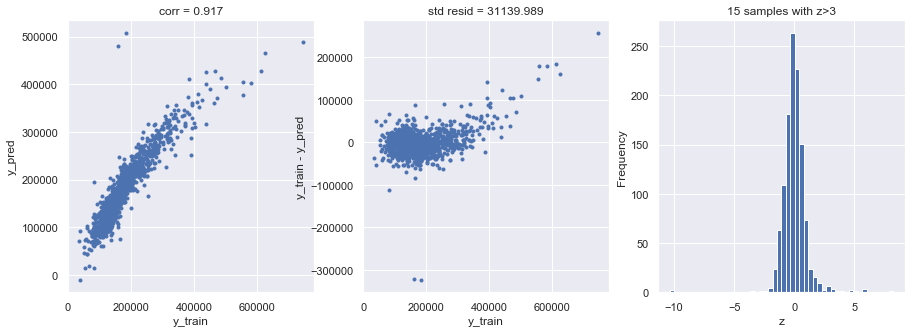

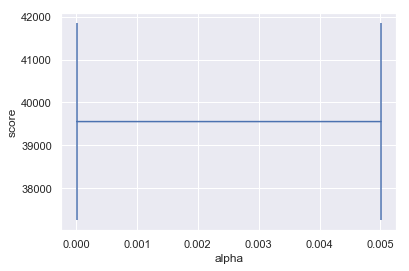

In [309]:
lasso = Lasso()
alph_range = np.arange(0.00001,0.01,0.005)
param_grid = {'alpha': alph_range}
best_lasso_Model,cv_score,grid_results= train_Model(lasso, param_grid=param_grid)


plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(5*5))
plt.xlabel('alpha')
plt.ylabel('score');

In [313]:
## Grid search method might be needed
clf1 = Lasso(alpha = 0.0002)
clf1.fit(X_train, y_train)

lasso_preds = np.expm1(clf1.predict(X_test))


<a id='xgboost'></a>
## Xgboost

In [314]:
import xgboost

Fitting 25 folds for each of 15 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  2.4min finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------
score= 0.9767541923834642
rmse= 11871.96107356883
cross_val: mean= 29069.111300101835 , std= 6114.32151658229


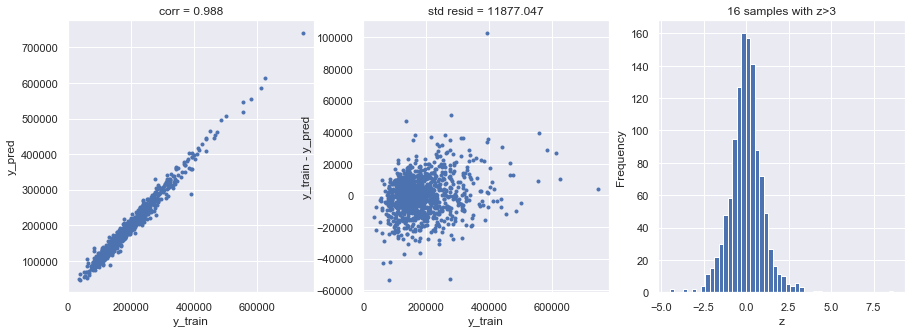

In [315]:
model_xgb = xgboost.XGBRegressor()
param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }
best_xgb, cv_score,grid_results = train_Model(model_xgb, param_grid=param_grid, )

In [316]:
# Create an xgboost model with leaning rate 0.05
##Grid search is needed

                 
model_xgb = xgboost.XGBRegressor( colsample_bytree=0.4,gamma=0.045,n_estimators=2000, learning_rate=0.01,subsample=0.95,reg_alpha=0.65,reg_lambda=0.45) 

In [317]:
# Training
model_xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:203193
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:201321
[2]	validation_0-rmse:199463
[3]	validation_0-rmse:197617
[4]	validation_0-rmse:195782
[5]	validation_0-rmse:193973
[6]	validation_0-rmse:192180
[7]	validation_0-rmse:190429
[8]	validation_0-rmse:188683
[9]	validation_0-rmse:186938
[10]	validation_0-rmse:185232
[11]	validation_0-rmse:183538
[12]	validation_0-rmse:181867
[13]	validation_0-rmse:180219
[14]	validation_0-rmse:178613
[15]	validation_0-rmse:176992
[16]	validation_0-rmse:175378
[17]	validation_0-rmse:173762
[18]	validation_0-rmse:172179
[19]	validation_0-rmse:170627
[20]	validation_0-rmse:169087
[21]	validation_0-rmse:167533
[22]	validation_0-rmse:165993
[23]	validation_0-rmse:164498
[24]	validation_0-rmse:163048
[25]	validation_0-rmse:161575
[26]	validation_0-rmse:160157
[27]	validation_0-rmse:158771
[28]	validation_0-rmse:157343
[29]	validation_0-rmse:155922
[30]	validation_0-rmse:154521
[31]	validatio

[261]	validation_0-rmse:35660.9
[262]	validation_0-rmse:35548.5
[263]	validation_0-rmse:35443.6
[264]	validation_0-rmse:35341.2
[265]	validation_0-rmse:35256.7
[266]	validation_0-rmse:35160.1
[267]	validation_0-rmse:35068.7
[268]	validation_0-rmse:34960.5
[269]	validation_0-rmse:34873.2
[270]	validation_0-rmse:34778.9
[271]	validation_0-rmse:34684.5
[272]	validation_0-rmse:34591.3
[273]	validation_0-rmse:34504.4
[274]	validation_0-rmse:34389.6
[275]	validation_0-rmse:34296.4
[276]	validation_0-rmse:34224.9
[277]	validation_0-rmse:34126.2
[278]	validation_0-rmse:34035.9
[279]	validation_0-rmse:33965.8
[280]	validation_0-rmse:33884.9
[281]	validation_0-rmse:33807.8
[282]	validation_0-rmse:33721.1
[283]	validation_0-rmse:33652.5
[284]	validation_0-rmse:33582.8
[285]	validation_0-rmse:33498
[286]	validation_0-rmse:33412.7
[287]	validation_0-rmse:33349.6
[288]	validation_0-rmse:33268.7
[289]	validation_0-rmse:33187.4
[290]	validation_0-rmse:33099.3
[291]	validation_0-rmse:33032.7
[292]	vali

[519]	validation_0-rmse:26797.2
[520]	validation_0-rmse:26795.4
[521]	validation_0-rmse:26779.5
[522]	validation_0-rmse:26773.3
[523]	validation_0-rmse:26764.3
[524]	validation_0-rmse:26752.7
[525]	validation_0-rmse:26743.5
[526]	validation_0-rmse:26729.8
[527]	validation_0-rmse:26717.6
[528]	validation_0-rmse:26710.4
[529]	validation_0-rmse:26704.8
[530]	validation_0-rmse:26693.8
[531]	validation_0-rmse:26682.8
[532]	validation_0-rmse:26670
[533]	validation_0-rmse:26664.8
[534]	validation_0-rmse:26658.9
[535]	validation_0-rmse:26651.7
[536]	validation_0-rmse:26648.2
[537]	validation_0-rmse:26643.3
[538]	validation_0-rmse:26639.6
[539]	validation_0-rmse:26636.7
[540]	validation_0-rmse:26632.3
[541]	validation_0-rmse:26624.1
[542]	validation_0-rmse:26612.5
[543]	validation_0-rmse:26602.7
[544]	validation_0-rmse:26583.9
[545]	validation_0-rmse:26579.7
[546]	validation_0-rmse:26577.9
[547]	validation_0-rmse:26576.3
[548]	validation_0-rmse:26566.6
[549]	validation_0-rmse:26568
[550]	valida

[777]	validation_0-rmse:25574
[778]	validation_0-rmse:25571.1
[779]	validation_0-rmse:25575.9
[780]	validation_0-rmse:25571.2
[781]	validation_0-rmse:25577.7
[782]	validation_0-rmse:25582.9
[783]	validation_0-rmse:25585.2
[784]	validation_0-rmse:25580.1
[785]	validation_0-rmse:25578
[786]	validation_0-rmse:25578.2
[787]	validation_0-rmse:25578.7
[788]	validation_0-rmse:25583.3
[789]	validation_0-rmse:25581.2
[790]	validation_0-rmse:25573.3
[791]	validation_0-rmse:25571.3
[792]	validation_0-rmse:25570
[793]	validation_0-rmse:25565.3
[794]	validation_0-rmse:25564.9
[795]	validation_0-rmse:25565.2
[796]	validation_0-rmse:25564.6
[797]	validation_0-rmse:25565.9
[798]	validation_0-rmse:25562.5
[799]	validation_0-rmse:25556
[800]	validation_0-rmse:25556.4
[801]	validation_0-rmse:25555.2
[802]	validation_0-rmse:25554.9
[803]	validation_0-rmse:25553.1
[804]	validation_0-rmse:25554
[805]	validation_0-rmse:25554.5
[806]	validation_0-rmse:25555
[807]	validation_0-rmse:25550.5
[808]	validation_0-r

[1034]	validation_0-rmse:25224.2
[1035]	validation_0-rmse:25225.7
[1036]	validation_0-rmse:25224.1
[1037]	validation_0-rmse:25217.6
[1038]	validation_0-rmse:25217
[1039]	validation_0-rmse:25216.6
[1040]	validation_0-rmse:25210.5
[1041]	validation_0-rmse:25208.9
[1042]	validation_0-rmse:25208.8
[1043]	validation_0-rmse:25205.3
[1044]	validation_0-rmse:25207.4
[1045]	validation_0-rmse:25207.2
[1046]	validation_0-rmse:25205.5
[1047]	validation_0-rmse:25201.6
[1048]	validation_0-rmse:25194.9
[1049]	validation_0-rmse:25191.1
[1050]	validation_0-rmse:25190.2
[1051]	validation_0-rmse:25191.4
[1052]	validation_0-rmse:25190.3
[1053]	validation_0-rmse:25189.4
[1054]	validation_0-rmse:25189
[1055]	validation_0-rmse:25187
[1056]	validation_0-rmse:25188.4
[1057]	validation_0-rmse:25189.2
[1058]	validation_0-rmse:25188.7
[1059]	validation_0-rmse:25185.9
[1060]	validation_0-rmse:25177.3
[1061]	validation_0-rmse:25177.8
[1062]	validation_0-rmse:25180.9
[1063]	validation_0-rmse:25180
[1064]	validation_

[1284]	validation_0-rmse:25014.2
[1285]	validation_0-rmse:25014.5
[1286]	validation_0-rmse:25014
[1287]	validation_0-rmse:25016.1
[1288]	validation_0-rmse:25015.7
[1289]	validation_0-rmse:25011.9
[1290]	validation_0-rmse:25011.2
[1291]	validation_0-rmse:25011
[1292]	validation_0-rmse:25009.9
[1293]	validation_0-rmse:25009.6
[1294]	validation_0-rmse:25010.5
[1295]	validation_0-rmse:25007.7
[1296]	validation_0-rmse:25008.4
[1297]	validation_0-rmse:25008.9
[1298]	validation_0-rmse:25009.3
[1299]	validation_0-rmse:25006.1
[1300]	validation_0-rmse:25008.8
[1301]	validation_0-rmse:25006.7
[1302]	validation_0-rmse:25008.1
[1303]	validation_0-rmse:25003.2
[1304]	validation_0-rmse:25002.7
[1305]	validation_0-rmse:25008.3
[1306]	validation_0-rmse:25009.2
[1307]	validation_0-rmse:25006.4
[1308]	validation_0-rmse:25006.6
[1309]	validation_0-rmse:25010.3
[1310]	validation_0-rmse:25013.1
[1311]	validation_0-rmse:25014.4
[1312]	validation_0-rmse:25012.7
[1313]	validation_0-rmse:25012.6
[1314]	validat

[1534]	validation_0-rmse:24928.3
[1535]	validation_0-rmse:24928.9
[1536]	validation_0-rmse:24924.7
[1537]	validation_0-rmse:24924.9
[1538]	validation_0-rmse:24925.2
[1539]	validation_0-rmse:24924.9
[1540]	validation_0-rmse:24929
[1541]	validation_0-rmse:24927.5
[1542]	validation_0-rmse:24929.9
[1543]	validation_0-rmse:24929.2
[1544]	validation_0-rmse:24928.9
[1545]	validation_0-rmse:24927.5
[1546]	validation_0-rmse:24926.3
[1547]	validation_0-rmse:24925
[1548]	validation_0-rmse:24923.7
[1549]	validation_0-rmse:24923.6
[1550]	validation_0-rmse:24926.2
[1551]	validation_0-rmse:24927.2
[1552]	validation_0-rmse:24926.9
[1553]	validation_0-rmse:24929.3
[1554]	validation_0-rmse:24928.4
[1555]	validation_0-rmse:24927.3
[1556]	validation_0-rmse:24927.4
[1557]	validation_0-rmse:24925.5
[1558]	validation_0-rmse:24925.9
[1559]	validation_0-rmse:24924.3
[1560]	validation_0-rmse:24924.1
[1561]	validation_0-rmse:24923.6
[1562]	validation_0-rmse:24925.9
[1563]	validation_0-rmse:24927
[1564]	validatio

[1785]	validation_0-rmse:24848.4
[1786]	validation_0-rmse:24848.2
[1787]	validation_0-rmse:24846.6
[1788]	validation_0-rmse:24846.4
[1789]	validation_0-rmse:24846.9
[1790]	validation_0-rmse:24847.9
[1791]	validation_0-rmse:24846.1
[1792]	validation_0-rmse:24845.6
[1793]	validation_0-rmse:24848
[1794]	validation_0-rmse:24848.5
[1795]	validation_0-rmse:24847.3
[1796]	validation_0-rmse:24846.8
[1797]	validation_0-rmse:24848.8
[1798]	validation_0-rmse:24848.4
[1799]	validation_0-rmse:24847.6
[1800]	validation_0-rmse:24847.3
[1801]	validation_0-rmse:24849.1
[1802]	validation_0-rmse:24849.2
[1803]	validation_0-rmse:24851.2
[1804]	validation_0-rmse:24849.4
[1805]	validation_0-rmse:24848.2
[1806]	validation_0-rmse:24849.7
[1807]	validation_0-rmse:24853.7
[1808]	validation_0-rmse:24853.7
[1809]	validation_0-rmse:24852.1
[1810]	validation_0-rmse:24850.6
[1811]	validation_0-rmse:24851.2
[1812]	validation_0-rmse:24852.7
[1813]	validation_0-rmse:24851.5
[1814]	validation_0-rmse:24851.7
[1815]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.045, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=2000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.65, reg_lambda=0.45, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.95)

In [318]:
y_test_xgb_ela = model_xgb.predict(X_test)

<a id='nn'></a>
### Neural Network Based Model

In [319]:
import keras

Using TensorFlow backend.


In [320]:
seed = 7
np.random.seed(seed)

In [321]:
# Create a model and add layers
kerasModel = keras.models.Sequential()

kerasModel.add(keras.layers.Dense(200, input_dim = X_train.shape[1],activation='relu'))
# kerasModel.add(keras.layers.Dense(400,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(300,kernel_initializer='normal',activation='relu'))
#kerasModel.add(keras.layers.Dense(200,kernel_initializer='normal',activation='relu'))
kerasModel.add(keras.layers.Dense(100,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(50,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(300,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(200,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(100,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(300,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(200,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(100,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(50,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(300,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(200,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(50,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(25,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(12,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(6,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(25,kernel_initializer='normal',activation='relu'))
# kerasModel.add(keras.layers.Dense(12,kernel_initializer='normal',activation='relu'))
kerasModel.add(keras.layers.Dense(50,kernel_initializer='normal',activation='relu'))
kerasModel.add(keras.layers.Dense(25,kernel_initializer='normal',activation='relu'))
kerasModel.add(keras.layers.Dense(12,kernel_initializer='normal',activation='relu'))
kerasModel.add(keras.layers.Dense(1,kernel_initializer='normal'))
kerasModel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               16000     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 42,750
Trainable params: 42,750
Non-trainable params: 0
_________________________________________________________________


## Number of layer searching method ==> Grid search can be used 

In [322]:
# Define another loss function
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [323]:
# Set loss function and optimizer
kerasModel.compile(loss = 'mse', optimizer = "adam")

In [324]:
# Set callback function which will ealystop when val_loss does not become better in 50 epochs
# save the best model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
            keras.callbacks.ModelCheckpoint('best.h5', monitor='val_loss', save_best_only=True, mode='min')]

In [112]:
## Train
history = kerasModel.fit(X_train, y_train, epochs=200, validation_data = (X_test, y_test))

Train on 1020 samples, validate on 438 samples
Epoch 1/200
1020/1020 [==============================] - 1s 753us/step - loss: 0.0843 - val_loss: 0.0490
Epoch 2/200
1020/1020 [==============================] - 1s 850us/step - loss: 0.0778 - val_loss: 0.0284
Epoch 3/200
1020/1020 [==============================] - 1s 867us/step - loss: 0.0097 - val_loss: 0.0788
Epoch 4/200
1020/1020 [==============================] - 1s 811us/step - loss: 0.0121 - val_loss: 0.0656
Epoch 5/200
1020/1020 [==============================] - 1s 828us/step - loss: 0.0205 - val_loss: 0.0245
Epoch 6/200
1020/1020 [==============================] - 1s 770us/step - loss: 0.0024 - val_loss: 0.0236
Epoch 7/200
1020/1020 [==============================] - 1s 814us/step - loss: 0.0094 - val_loss: 0.0282
Epoch 8/200
1020/1020 [==============================] - 1s 771us/step - loss: 0.0100 - val_loss: 0.0244
Epoch 9/200
1020/1020 [==============================] - 1s 795us/step - loss: 0.0256 - val_loss: 0.0899
Epoch 10

Epoch 78/200
1020/1020 [==============================] - 1s 956us/step - loss: 0.0137 - val_loss: 0.0280
Epoch 79/200
1020/1020 [==============================] - 1s 707us/step - loss: 0.0253 - val_loss: 0.0283
Epoch 80/200
1020/1020 [==============================] - 1s 771us/step - loss: 0.0220 - val_loss: 0.0253
Epoch 81/200
1020/1020 [==============================] - 1s 1ms/step - loss: 0.0575 - val_loss: 0.0278
Epoch 82/200
1020/1020 [==============================] - 1s 793us/step - loss: 0.0435 - val_loss: 0.0430
Epoch 83/200
1020/1020 [==============================] - 1s 1ms/step - loss: 0.0293 - val_loss: 0.0542
Epoch 84/200
1020/1020 [==============================] - 1s 1ms/step - loss: 0.0334 - val_loss: 0.0336
Epoch 85/200
1020/1020 [==============================] - 1s 1ms/step - loss: 0.0337 - val_loss: 0.0310
Epoch 86/200
1020/1020 [==============================] - 1s 963us/step - loss: 0.0349 - val_loss: 0.0510
Epoch 87/200
1020/1020 [==============================

1020/1020 [==============================] - 1s 861us/step - loss: 0.0118 - val_loss: 0.0251
Epoch 156/200
1020/1020 [==============================] - 1s 917us/step - loss: 0.0077 - val_loss: 0.0741
Epoch 157/200
1020/1020 [==============================] - 1s 918us/step - loss: 0.0182 - val_loss: 0.0267
Epoch 158/200
1020/1020 [==============================] - 1s 878us/step - loss: 0.0063 - val_loss: 0.0423
Epoch 159/200
1020/1020 [==============================] - 1s 768us/step - loss: 0.0259 - val_loss: 0.1269
Epoch 160/200
1020/1020 [==============================] - 1s 731us/step - loss: 0.0279 - val_loss: 0.0251
Epoch 161/200
1020/1020 [==============================] - 1s 754us/step - loss: 0.0262 - val_loss: 0.0280
Epoch 162/200
1020/1020 [==============================] - 1s 755us/step - loss: 0.0380 - val_loss: 0.1321
Epoch 163/200
1020/1020 [==============================] - 1s 831us/step - loss: 0.0380 - val_loss: 0.0249
Epoch 164/200
1020/1020 [==========================

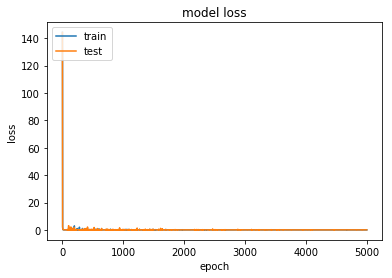

In [84]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
np.shape(kerasModel.predict(X_test))


(1459,)

In [179]:
np.shape(test.Id)

kerasModel.predict(X_test)

res=np.expm1(kerasModel.predict(test_X))

In [192]:
np.shape(test['Id'])

(1459,)

In [203]:
solution = pd.DataFrame({"id":test['Id'], "SalePrice":res[:,0]}, columns=['id', 'SalePrice'])
solution.to_csv("result.csv", index = False)


In [212]:
pred_xgb=model_xgb.predict(test_X)
sol=np.expm1(pred_xgb)

solution = pd.DataFrame({"id":test['Id'], "SalePrice":lasso_preds}, columns=['id', 'SalePrice'])
solution.to_csv("result.csv", index = False)


In [211]:
lasso_preds

array([116672.85921358, 164624.28738499, 180802.60358362, ...,
       165492.48298762, 116194.74934614, 215246.94362455])

<a id='results'></a>
### Results

Kaggle leaderboard.. Image attach 
The result suggests that ~ is best between ~
This algorithm end up top x% in the kaggle competitions.

<a id='limitation'></a>

### Limitation/Recommendations

Limitations/Recommendations
1. The training data and test dataset have a same length and the performance of the model might be improved that if we can obtain more dataset 

2. We realize that a lot of domain knowledg is requried 

3. Feature enginnering/ other types of model is required

4. The features were decided heuristic way but we are not sure we can't explain why the peformance of specific model is better

<a id='limitation'></a>
### Conclusion

Fidings from EDA- Which feature was included.. how we engineerined. Model fitting and validity of model tracking down. Our efforts to try to improve the performance. 
* Kaggle submission history

<a id='reference'></a>
### Reference/Resource

[1] https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset 

[2] https://github.com/Sooyeong/CSE627_project 

[3] https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions * grid search method

[4] https://www.kaggle.com/kernels/notebooks/new?forkParentScriptVersionId=3824453&userName=sylims6 Visualization& comparision